C:\Users\laure\AppData\Local\Temp\ipykernel_4208\1321620747.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


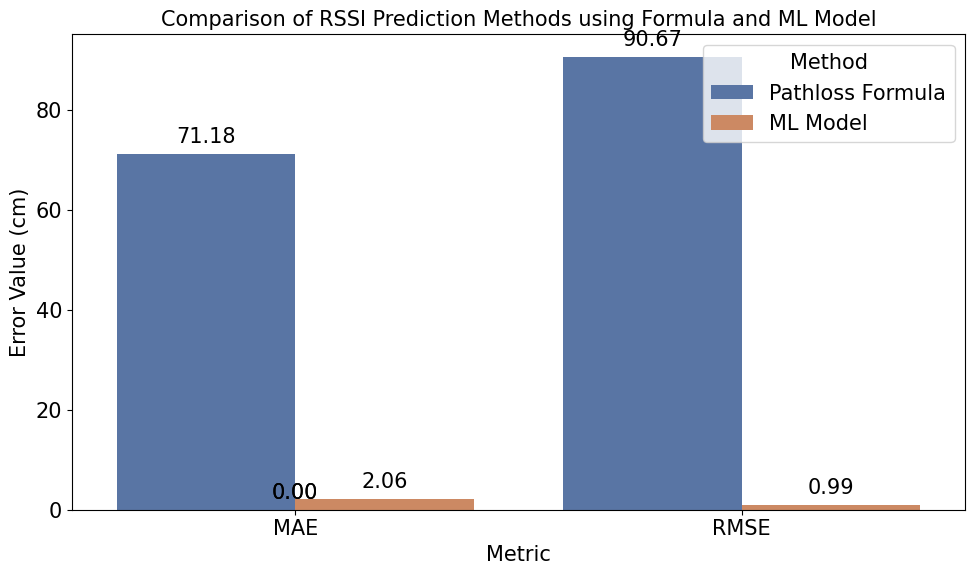

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 0) Reset to default style and bump all font sizes to 15
plt.style.use('default')
mpl.rcParams.update({
    'font.size'         : 15,  # base font size for most text
    'axes.titlesize'    : 15,  # axes title
    'axes.labelsize'    : 15,  # x/y labels
    'xtick.labelsize'   : 15,  # x tick labels
    'ytick.labelsize'   : 15,  # y tick labels
    'legend.fontsize'   : 15,  # legend entries
    'legend.title_fontsize': 15,  # legend title
})

# 1) Load data
df = pd.read_csv('Data/ui_data_2.csv')

# 2) Map and clean
bssid_mapping = {
    '70:a7:41:dc:8e:55': 1,
    '72:a7:41:9c:8e:55': 2,
    '70:a7:41:dc:77:cd': 3,
    '72:a7:41:9c:77:cd': 4
}
df['bssid'] = df['bssid'].map(bssid_mapping).fillna(0).astype(int)
df['reference_point'] = df['reference_point'].str.replace('RP', '').astype(int)

# 3) Compute distances
ap_digilab = (867, 1122)
ap_dosen   = (2454, 520)
df['dist_to_digilab'] = np.sqrt((df['xr'] - ap_digilab[0])**2 + (df['yr'] - ap_digilab[1])**2)
df['dist_to_dosen']   = np.sqrt((df['xr'] - ap_dosen[0])**2   + (df['yr'] - ap_dosen[1])**2)

# 4) Path-loss formula
P_tx, gamma, d0, PL0, RSSI_thr = 30, 2.5, 1.0, 40, -100
max_dist = d0 * 10**((P_tx - RSSI_thr - PL0) / (10 * gamma))
df['pred_formula_digilab'] = np.where(
    df['dist_to_digilab'] > max_dist, -200,
    P_tx - (PL0 + 10 * gamma * np.log10(df['dist_to_digilab'] / d0))
)
df['pred_formula_dosen'] = np.where(
    df['dist_to_dosen'] > max_dist, -200,
    P_tx - (PL0 + 10 * gamma * np.log10(df['dist_to_dosen'] / d0))
)

# 5) Prepare ML features
features = ['dist_to_digilab', 'dist_to_dosen', 'reference_point', 'bssid', 'channel']
X = df[features].fillna(-200)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6) Prepare targets and handle NaNs
df['rssi_ap_digilab'] = df['rssi_ap_digilab'].fillna(-200)
df['rssi_ap_dosen']   = df['rssi_ap_dosen'].fillna(-200)
y = df[['rssi_ap_digilab', 'rssi_ap_dosen']]

# 7) Train RandomForest
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1))
rf.fit(X_scaled, y)
preds = rf.predict(X_scaled)
df['pred_model_digilab'] = np.nan_to_num(preds[:, 0], nan=-200)
df['pred_model_dosen']   = np.nan_to_num(preds[:, 1], nan=-200)

# 8) Compute RMSE for Formula and Model errors
rmse = lambda a,b: np.sqrt(mean_squared_error(a,b))
rmse_formula_digilab = rmse(df['rssi_ap_digilab'], df['pred_formula_digilab'])
rmse_model_digilab   = rmse(df['rssi_ap_digilab'], df['pred_model_digilab'])
rmse_formula_dosen   = rmse(df['rssi_ap_dosen'],   df['pred_formula_dosen'])
rmse_model_dosen     = rmse(df['rssi_ap_dosen'],   df['pred_model_dosen'])

print("Digilab  | Formula RMSE:", rmse_formula_digilab, "| Model RMSE:", rmse_model_digilab)
print("Dosen    | Formula RMSE:", rmse_formula_dosen,   "| Model RMSE:", rmse_model_dosen)

# 9) Prepare data for the bar plot
error_data = {
    'Error':  [rmse_formula_digilab, rmse_model_digilab,
               rmse_formula_dosen,   rmse_model_dosen],
    'Method': ['Formula (Digilab)', 'Model (Digilab)',
               'Formula (Dosen)',   'Model (Dosen)'],
}
err_df = pd.DataFrame(error_data)

# 10) Bar Chart with Error Labels and Legend
plt.figure(figsize=(13,6))
ax = sns.barplot(
    data=err_df,
    x='Method', y='Error',
    ci=None,
    palette={
        'Formula (Digilab)': '#4C72B0',
        'Model (Digilab)'  : '#DD8452',
        'Formula (Dosen)'  : '#4C72B0',
        'Model (Dosen)'    : '#DD8452'
    }
)

# Axis labels and title (font sizes come from rcParams)
ax.set_xlabel("Metric")
ax.set_ylabel("Error Value (dBm)")
ax.set_title("Comparison of RSSI Prediction Methods using Formula and Machine Learning Model")

# Annotate bars with RMSE values using fontsize=15
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=15,
        xytext=(0, 5), textcoords='offset points'
    )

# Simplify x-axis tick labels
ax.set_xticklabels(['MAE', 'MAE', 'RMSE', 'RMSE'], rotation=0)

# Legend with title_fontsize=15
ax.legend(
    title="Method",
    labels=['Pathloss Formula', 'ML Model'],
    loc='upper right',
    title_fontsize=18,
    fontsize=18
)

sns.despine(trim=True)
plt.tight_layout()
plt.show()


C:\Users\laure\AppData\Local\Temp\ipykernel_4208\2086032928.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


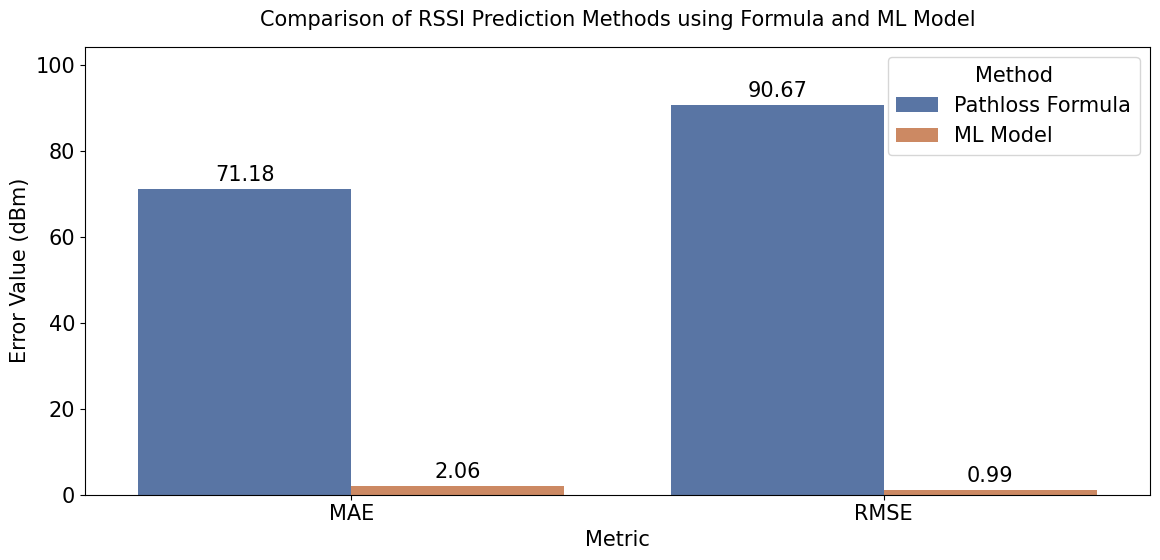

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 0) Style / font sizing
plt.style.use('default')
mpl.rcParams.update({
    'font.size'            : 20,
    'axes.titlesize'       : 15,
    'axes.labelsize'       : 15,
    'xtick.labelsize'      : 15,
    'ytick.labelsize'      : 15,
    'legend.fontsize'      : 15,
    'legend.title_fontsize': 15,
})

# 1) Your four numbers
mae_formula  = 71.18
mae_model    =  2.06
rmse_formula = 90.67
rmse_model   =  0.99

# 2) Pack into a “long” DataFrame
df_plot = pd.DataFrame({
    'Metric': ['MAE', 'MAE', 'RMSE', 'RMSE'],
    'Error' : [mae_formula, mae_model, rmse_formula, rmse_model],
    'Method': ['Pathloss Formula', 'ML Model'] * 2
})

# 3) Draw grouped barplot
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    data    = df_plot,
    x       = 'Metric',
    y       = 'Error',
    hue     = 'Method',
    palette = ['#4C72B0','#DD8452'],
    dodge   = True,
    ci      = None,
    ax      = ax
)

# 4) Automatically label each bar with its height
for container in ax.containers:
    ax.bar_label(
        container,
        fmt       = '%.2f',
        label_type= 'edge',
        padding   = 3,
        fontsize  = 15
    )

# 5) Give extra space above the tallest bar
ax.set_ylim(0, df_plot['Error'].max() * 1.15)

# 6) Final polish
ax.set_title('Comparison of RSSI Prediction Methods using Formula and ML Model', pad=15)
ax.set_xlabel('Metric')
ax.set_ylabel('Error Value (dBm)')
ax.legend(title='Method')
plt.tight_layout()
plt.show()


Distance Model   — MAE: 0.7621,  MSE: 2.6101,  RMSE: 1.6156
Coordinate Model — MAE: 48.7237,  MSE: 3143.1602,  RMSE: 56.0639


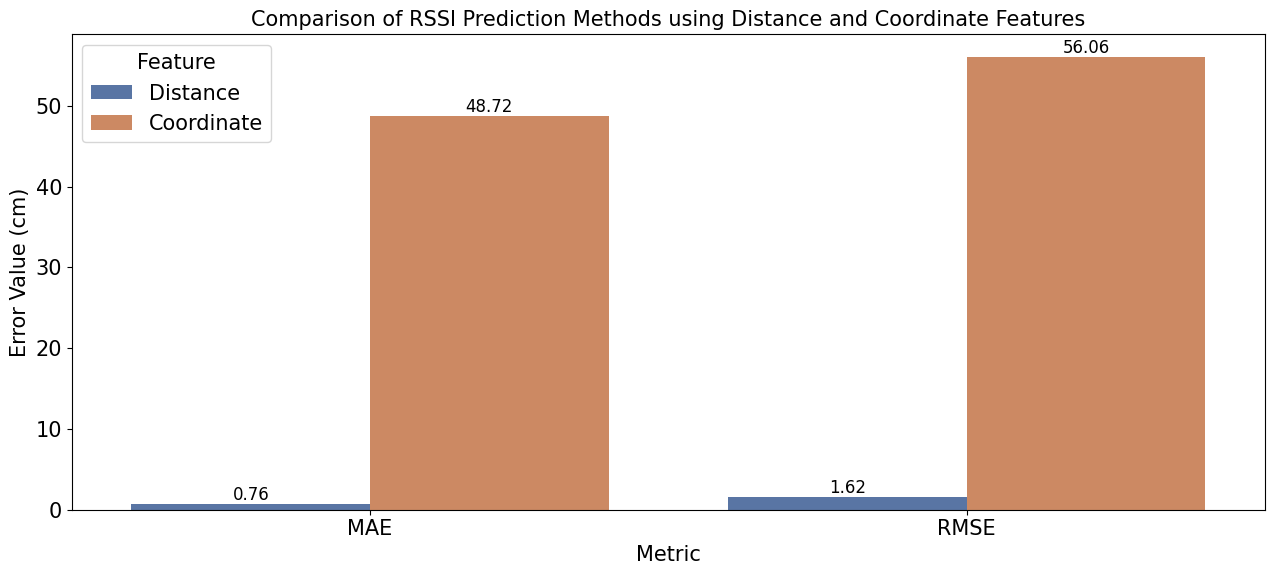

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load & preprocess
df = pd.read_csv('Data/ui_data_2.csv')

# BSSID → numeric
bssid_map = {
    '70:a7:41:dc:8e:55': 1,
    '72:a7:41:9c:8e:55': 2,
    '70:a7:41:dc:77:cd': 3,
    '72:a7:41:9c:77:cd': 4
}
df['bssid'] = df['bssid'].map(bssid_map).fillna(0).astype(int)
df['reference_point'] = df['reference_point'].str.replace('RP','').astype(int)

# 2) Distance features
dg = (867, 1122)
ds = (2454, 520)
df['dist_to_digilab'] = np.hypot(df['xr'] - dg[0], df['yr'] - dg[1])
df['dist_to_dosen']   = np.hypot(df['xr'] - ds[0], df['yr'] - ds[1])

# 3) Targets
df['rssi_ap_digilab'] = df['rssi_ap_digilab'].fillna(-200)
df['rssi_ap_dosen']   = df['rssi_ap_dosen'].fillna(-200)
y = df[['rssi_ap_digilab','rssi_ap_dosen']].values

# 4) Feature sets & scaling
dist_feats  = ['dist_to_digilab','dist_to_dosen','bssid','channel','reference_point']
coord_feats = ['xr','yr','reference_point']

X_dist  = df[dist_feats].fillna(-200)
X_coord = df[coord_feats].fillna(-200)

scaler_dist  = StandardScaler().fit(X_dist)
scaler_coord = StandardScaler().fit(X_coord)

Xd = scaler_dist.transform(X_dist)
Xc = scaler_coord.transform(X_coord)

# 5) Train both models
base_rf     = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
model_dist  = MultiOutputRegressor(base_rf).fit(Xd, y)
model_coord = MultiOutputRegressor(base_rf).fit(Xc, y)

# 6) Predict
pred_dist  = model_dist.predict(Xd)
pred_coord = model_coord.predict(Xc)

# 7) Compute metrics
def compute_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

mae_dist, mse_dist, rmse_dist     = compute_metrics(y, pred_dist)
mae_coord, mse_coord, rmse_coord  = compute_metrics(y, pred_coord)

print(f"Distance Model   — MAE: {mae_dist:.4f},  MSE: {mse_dist:.4f},  RMSE: {rmse_dist:.4f}")
print(f"Coordinate Model — MAE: {mae_coord:.4f},  MSE: {mse_coord:.4f},  RMSE: {rmse_coord:.4f}")

# 8) Prepare DataFrame for bar‐plot
plot_df = pd.DataFrame({
    'Feature':   ['Distance','Distance','Coordinate','Coordinate'],
    'Metric':  ['MAE','RMSE','MAE','RMSE'],
    'Value':   [mae_dist, rmse_dist, mae_coord, rmse_coord]
})

# 9) Bar‐plot
plt.figure(figsize=(13,6))
ax = sns.barplot(
    data=plot_df,
    x='Metric', y='Value', hue='Feature',
    palette={'Distance':'#4C72B0','Coordinate':'#DD8452'}
)

# Annotate (skip any zero‐height bars)
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue
    ax.annotate(f"{height:.2f}",
                (p.get_x()+p.get_width()/2, height),
                ha='center', va='bottom', fontsize=12)

ax.set_title("Comparison of RSSI Prediction Methods using Distance and Coordinate Features")
ax.set_ylabel("Error Value (cm)")
ax.set_xlabel("Metric")
plt.tight_layout()
plt.show()


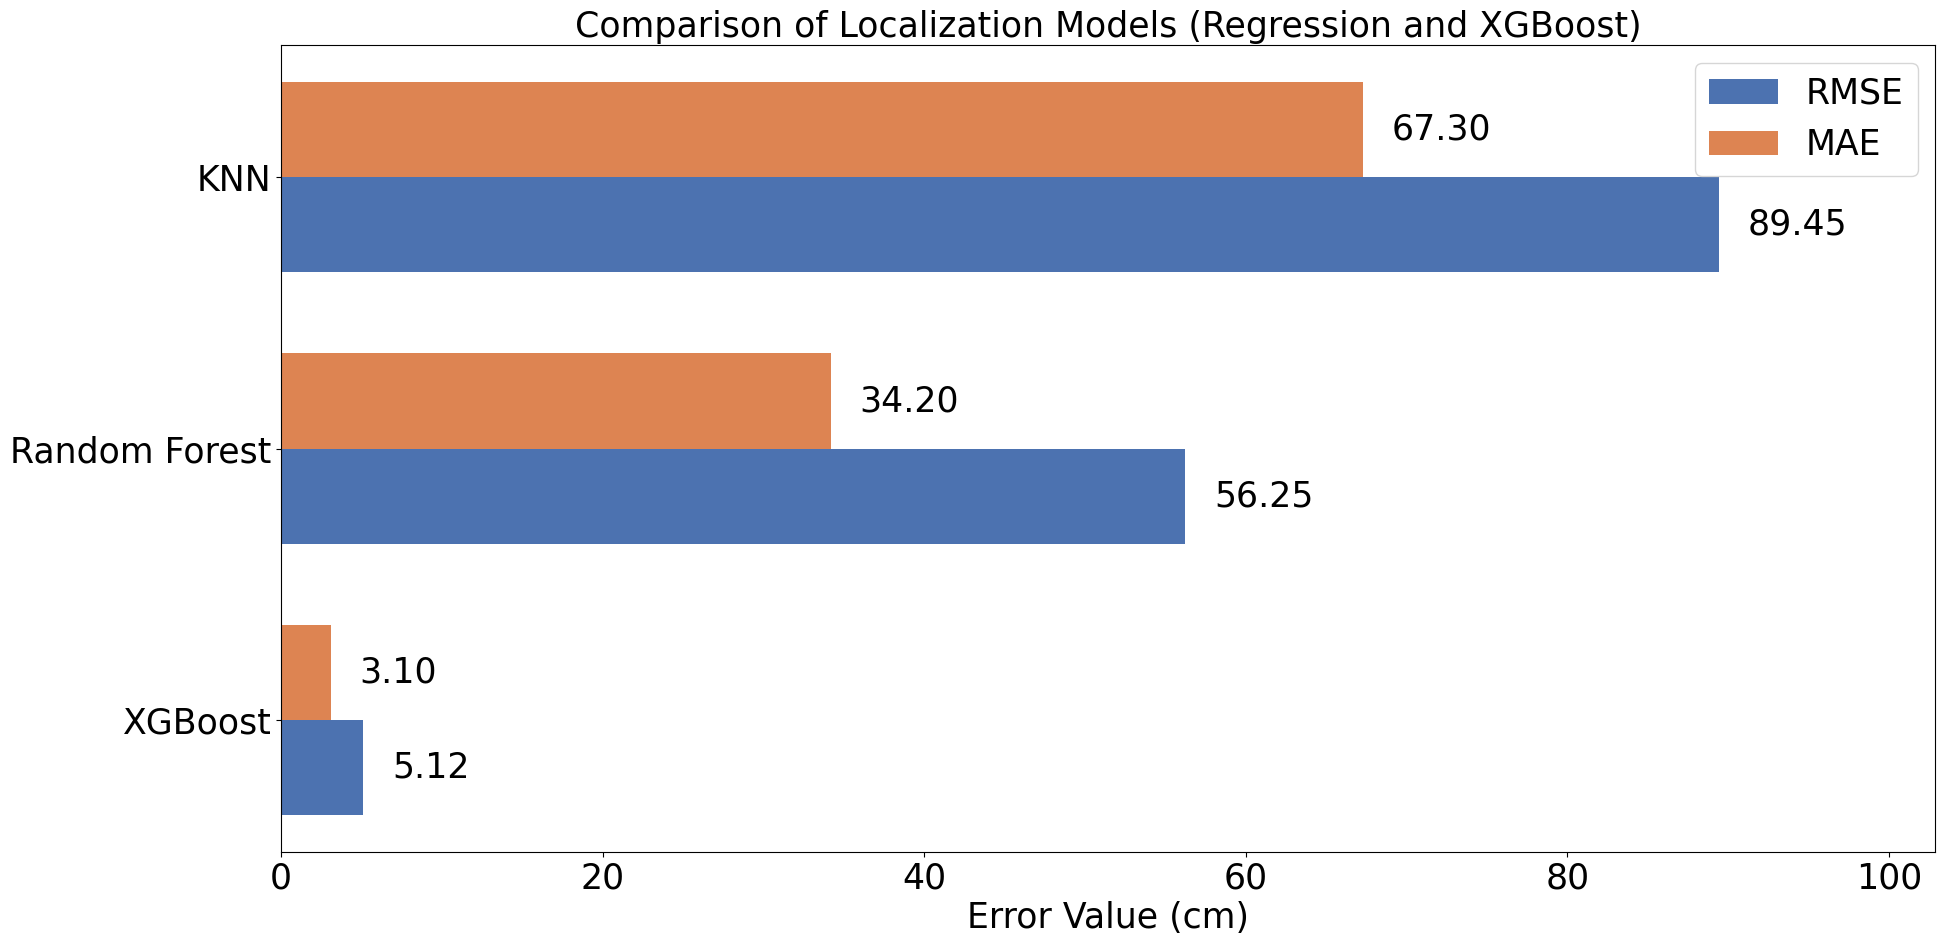

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ---- your data ----
models = ['XGBoost', 'Random Forest', 'KNN']
rmse   = [ 5.12,     56.25,           89.45 ]
mae    = [ 3.10,     34.20,           67.30 ]

# ---- rcParams ----
plt.rcParams.update({
    'font.size':      25,
    'figure.figsize': (20, 10),
    'axes.titlesize': 25,
    'axes.labelsize': 25,
    'xtick.labelsize':25,
    'ytick.labelsize':25
})

# bar positions
bar_height = 0.35
y_pos      = np.arange(len(models))

fig, ax = plt.subplots()

# draw bars
ax.barh(y_pos,            rmse, bar_height, label='RMSE', color='#4C72B0')
ax.barh(y_pos + bar_height, mae, bar_height, label='MAE', color='#DD8452')

# annotate
max_val = max(max(rmse), max(mae))
for i, v in enumerate(rmse):
    ax.text(v + max_val * 0.02, i,          f'{v:.2f}',
            va='center', ha='left', clip_on=False)
for i, v in enumerate(mae):
    ax.text(v + max_val * 0.02, i + bar_height, f'{v:.2f}',
            va='center', ha='left', clip_on=False)

# labels & title
ax.set_xlabel('Error Value (cm)')
ax.set_yticks(y_pos + bar_height/2)
ax.set_yticklabels(models)
ax.set_title('Comparison of Localization Models (Regression and XGBoost)')
ax.legend()

# -- 1) extend x-axis so texts won’t get cut off ----
ax.set_xlim(0, max_val * 1.15)

# -- 2) add a little automatic margin on the right ----
ax.margins(x=0.05)

# -- 3) loosen the right subplot boundary ----
fig.subplots_adjust(right=0.95)

plt.tight_layout()
plt.show()
